In [14]:
# Dependencies and Setup
import hvplot.pandas
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import scipy.stats as st
from scipy.stats import linregress
import requests
import json
import seaborn

#import api key
from JRS_api_keys import geoapify_key

#Turn off warning messages
import warnings
warnings.filterwarnings("ignore")


In [16]:
# Read the data
data = pd.read_csv("Resources/Life_happiness_mergedupdate.csv",index_col=0)
data_2015 = pd.read_csv("Resources/2015_Life_happiness_mergedupdate.csv",index_col=0)

# Display the data table for preview
data

,Country,happiness_score,gdp_per_capita,family,health,freedom,generosity,government_trust,dystopia_residual,continent,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,3.7940,0.401477,0.581543,0.180747,0.106180,0.311871,0.061158,2.150801,Asia,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,3.5750,0.319820,0.302850,0.303350,0.234140,0.365100,0.097190,1.952100,Asia,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
2,Afghanistan,3.2030,0.350000,0.000000,0.361000,0.000000,0.158000,0.025000,0.000000,Asia,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
3,Afghanistan,3.6320,0.332000,0.000000,0.255000,0.085000,0.191000,0.036000,0.000000,Asia,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
4,Afghanistan,3.3600,0.382270,0.110370,0.173440,0.164300,0.312680,0.071120,2.145580,Asia,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12693,Zimbabwe,4.6100,0.271000,1.032760,0.334750,0.258610,0.189870,0.080790,2.441910,Africa,...,78.0,7.10,78.0,43.5,547.358878,12222251.0,11.0,11.2,0.434,9.8
12694,Zimbabwe,3.6630,0.366000,0.000000,0.433000,0.361000,0.151000,0.089000,0.000000,Africa,...,78.0,7.10,78.0,43.5,547.358878,12222251.0,11.0,11.2,0.434,9.8
12695,Zimbabwe,3.6920,0.357000,0.000000,0.248000,0.406000,0.132000,0.099000,0.000000,Africa,...,78.0,7.10,78.0,43.5,547.358878,12222251.0,11.0,11.2,0.434,9.8
12696,Zimbabwe,4.1930,0.350410,0.714780,0.159500,0.254290,0.185030,0.085820,2.442700,Africa,...,78.0,7.10,78.0,43.5,547.358878,12222251.0,11.0,11.2,0.434,9.8


In [ ]:
#copy columns required for mapping from original data
happy_map_df = LH2015_dataf[['Country', 'happiness_score', 'Life expectancy ']].copy()

#add columns for lat & long
happy_map_df["Latitude"] = ""
happy_map_df["Longitude"] = ""
#fill the dataframe with lat & long details from Geoapify

#base URL & parameters
base_url = "https://api.geoapify.com/v1/geocode/search?"

params = {
    "apiKey": geoapify_key,
    "format": "json"
}

#iterrate through the copied df to find lat/long detail and add to the df
for index, row in happy_map_df.iterrows():

    #grab the country name for this row
    country = row["Country"]
    params["text"] = f"{country}"

    #make the request to the API and convert
    response = requests.get(base_url, params=params)
    response = response.json()

    #find the lat/long detail and add to the df
    try:
        happy_map_df.loc[index, "Latitude"] = response["results"][0]["lat"]
        happy_map_df.loc[index, "Longitude"] = response["results"][0]["lon"]
    #add a warning just in case there is a country not found
    except KeyError as e:
        print(f'{e.args[0]} not found for {happy_map_df.loc[index, "Country"]}')


In [ ]:
#map the countries with dot size based on happiness
#%%capture --no-display

happy_plot = happy_map_df.hvplot.points(
    "Longitude",
    "Latitude",
    geo = True,
    tiles = "OSM",
    frame_width = 700,
    frame_height = 500,
    size = "happiness_score",
    color = "Country"
)

happy_plot

In [20]:
# Select the top ten countries with average life expectancy for analysis
years=data.loc[:,["Year_x","Life expectancy "]].groupby("Year_x").mean().reset_index().sort_values("Life expectancy ",ascending=False)["Year_x"].values.tolist()
print(years)

[2015.0, 2016.0, 2017.0, 2018.0, 2019.0, 2020.0]


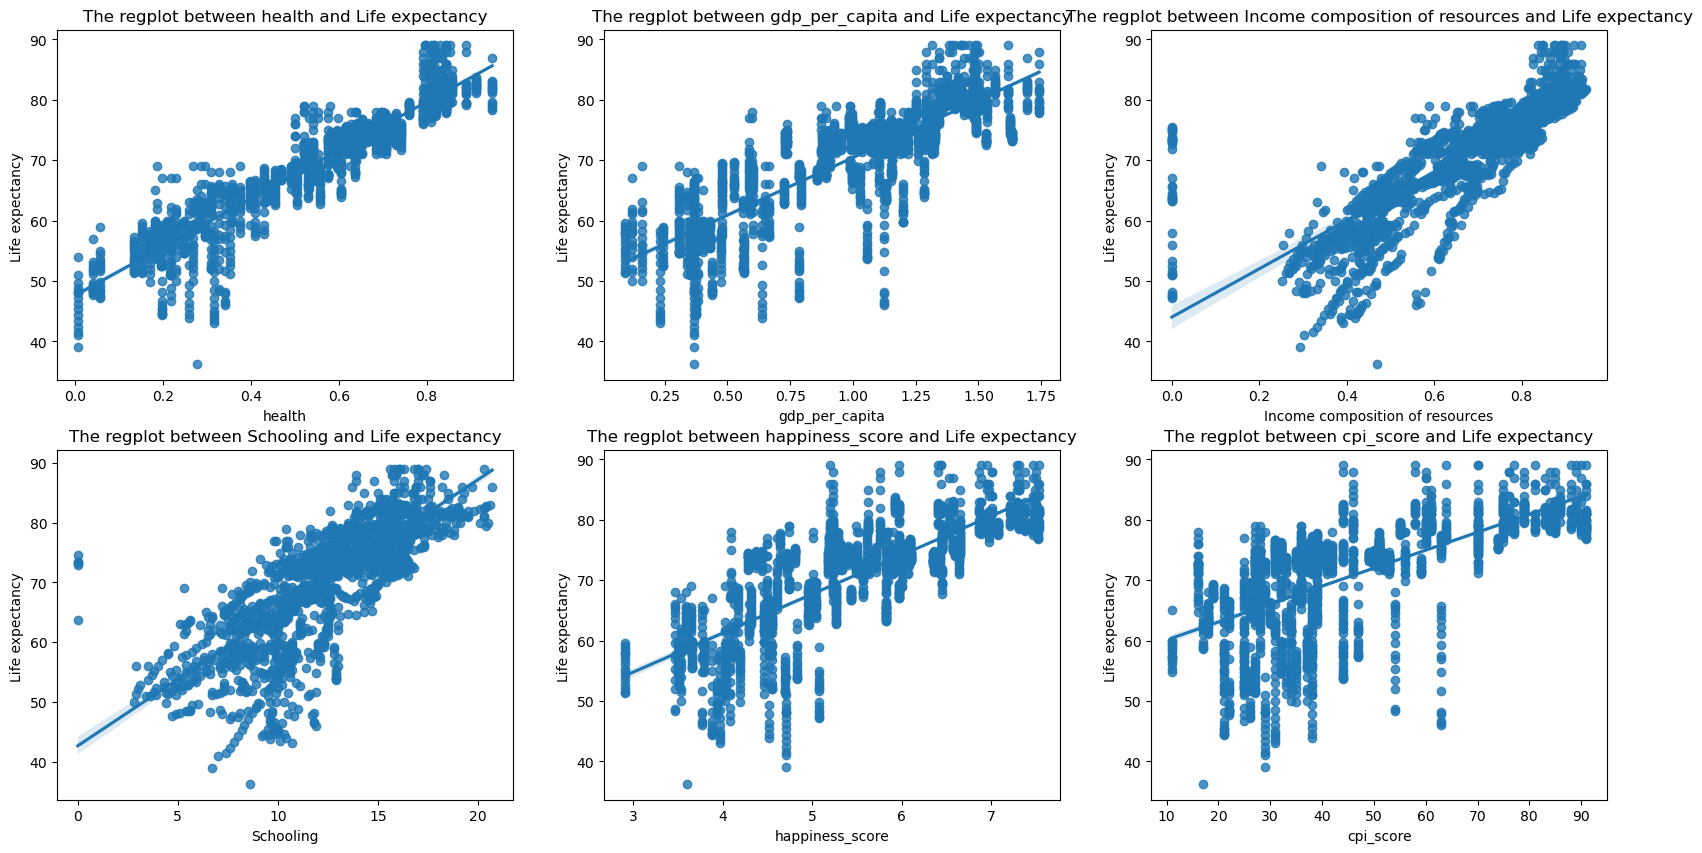

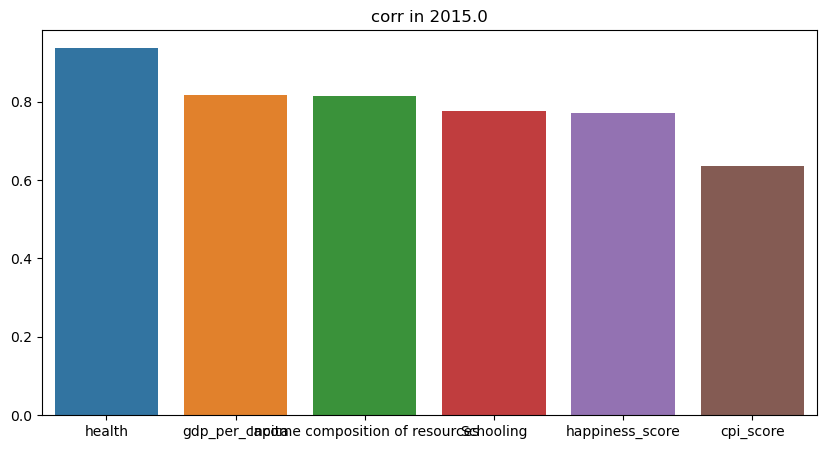

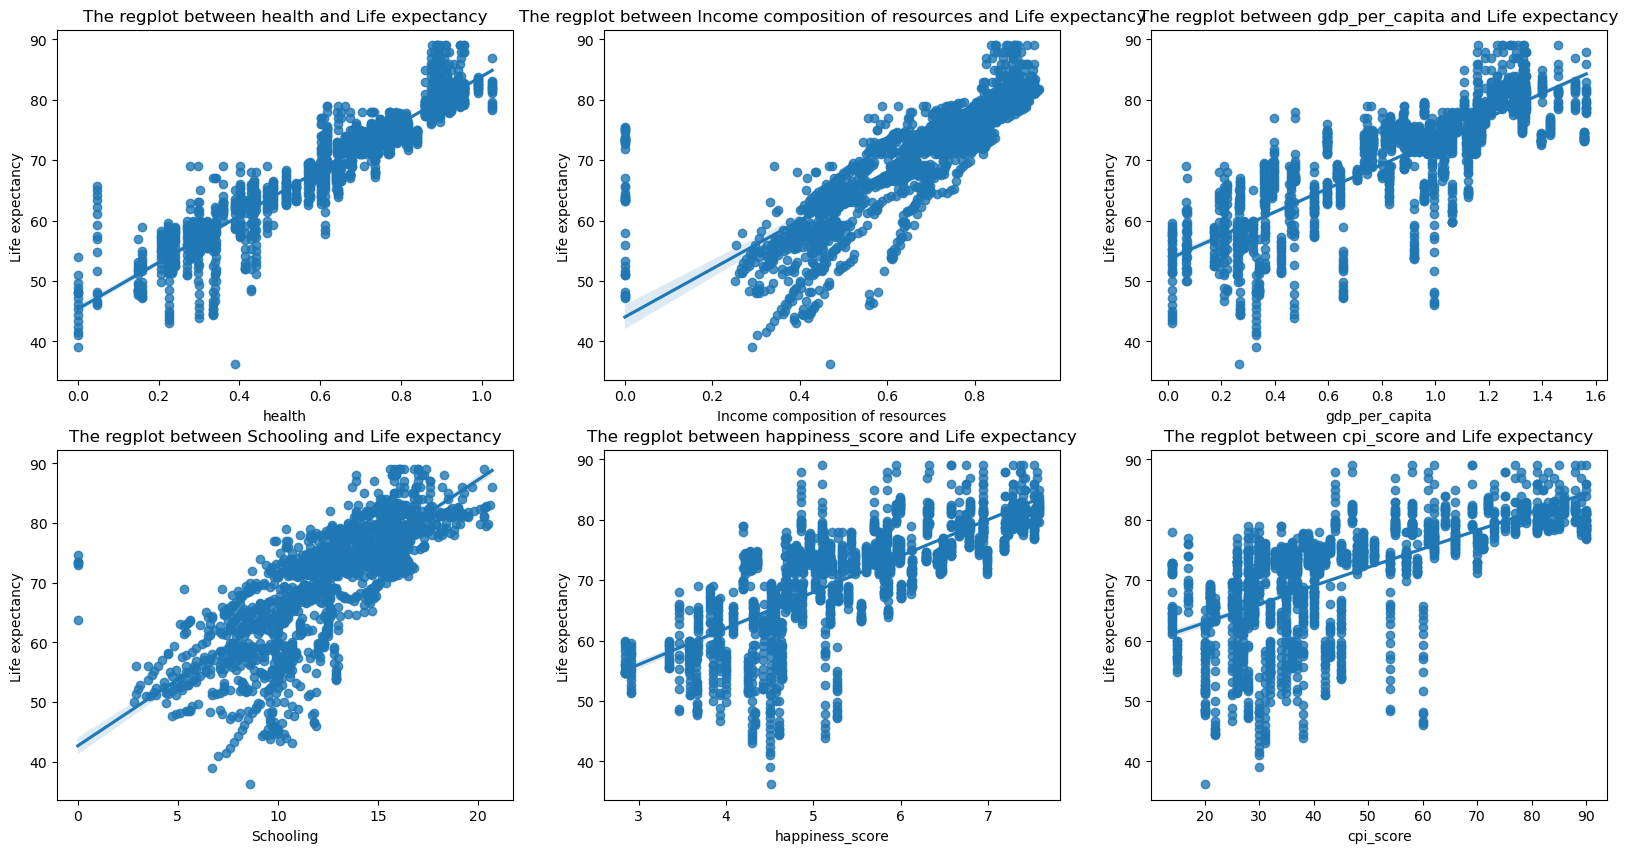

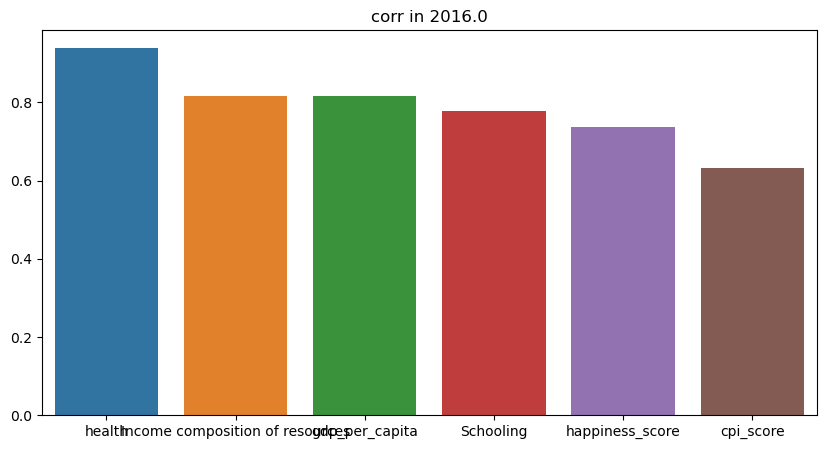

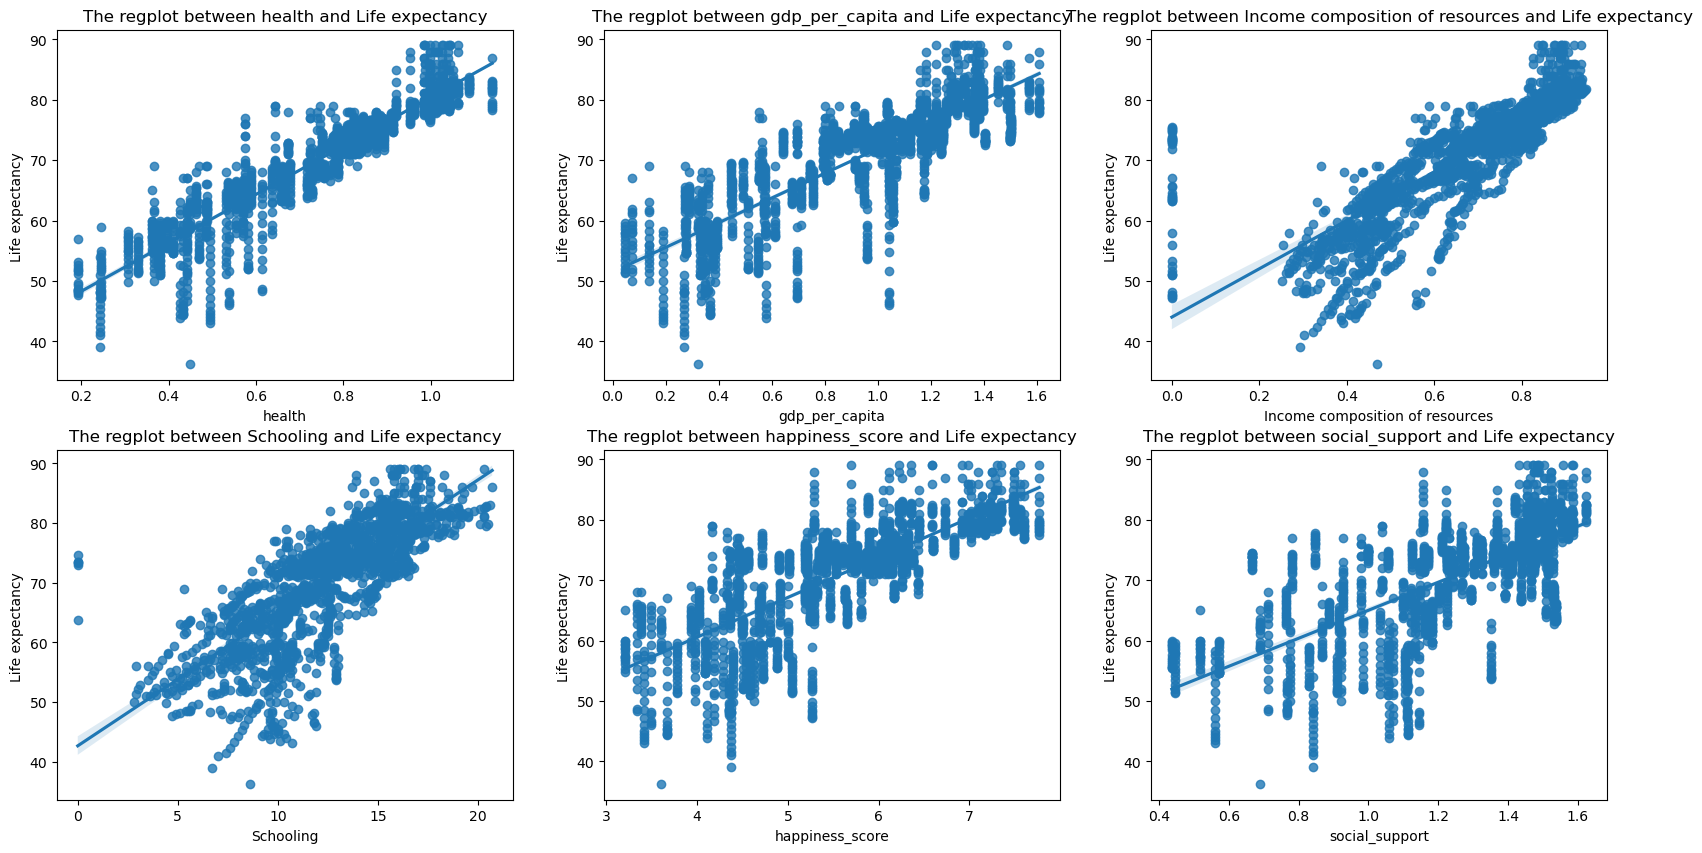

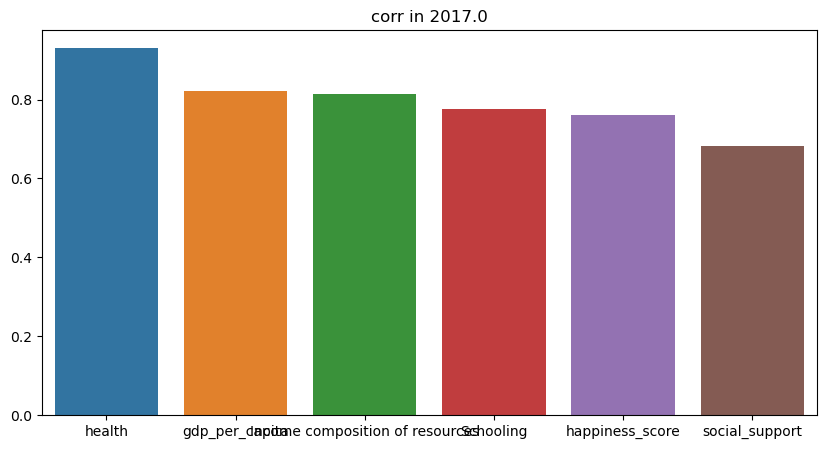

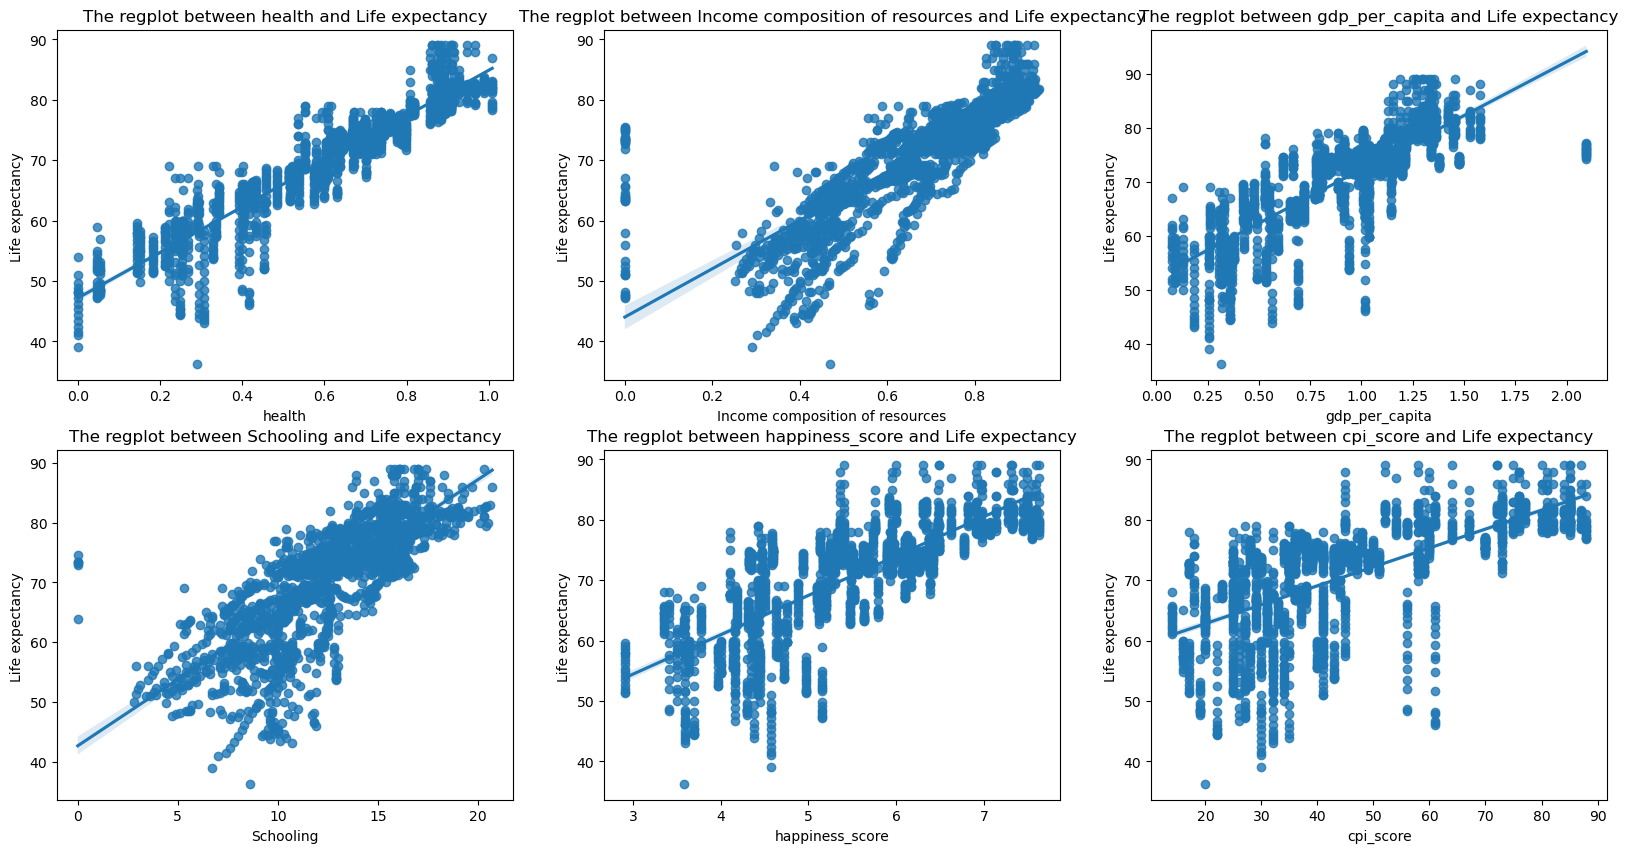

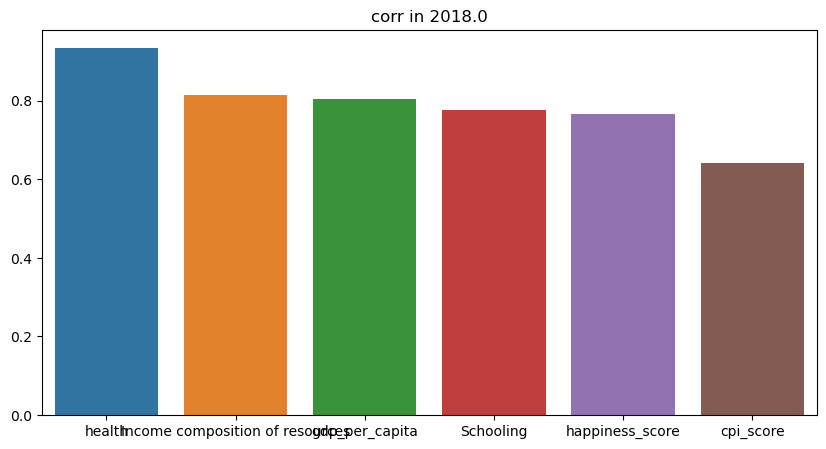

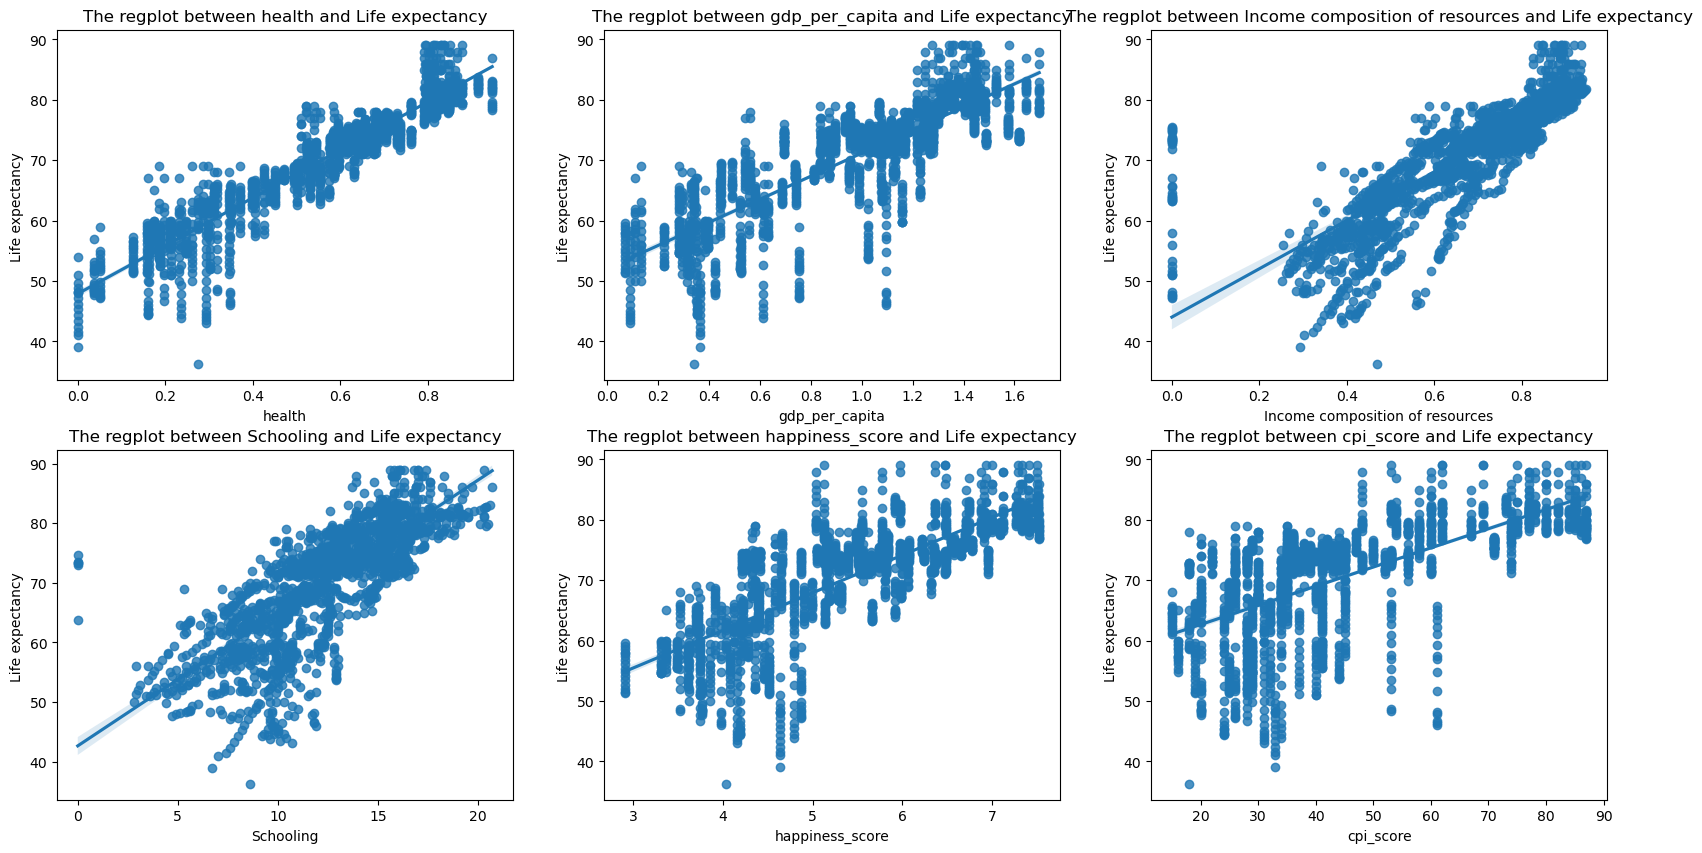

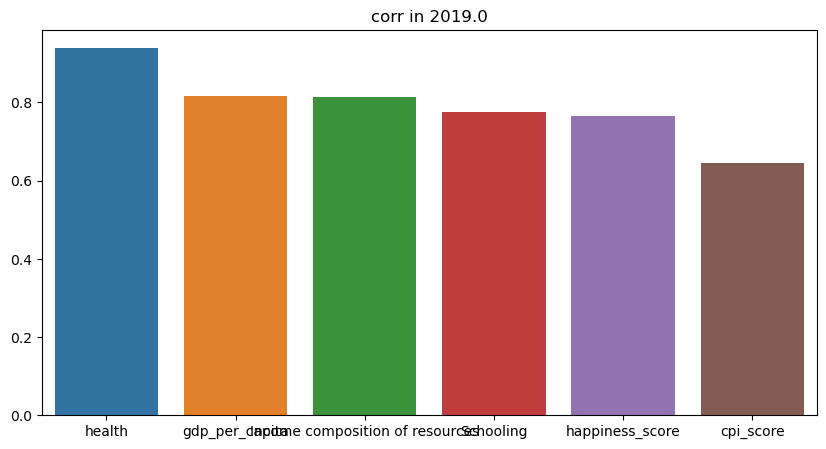

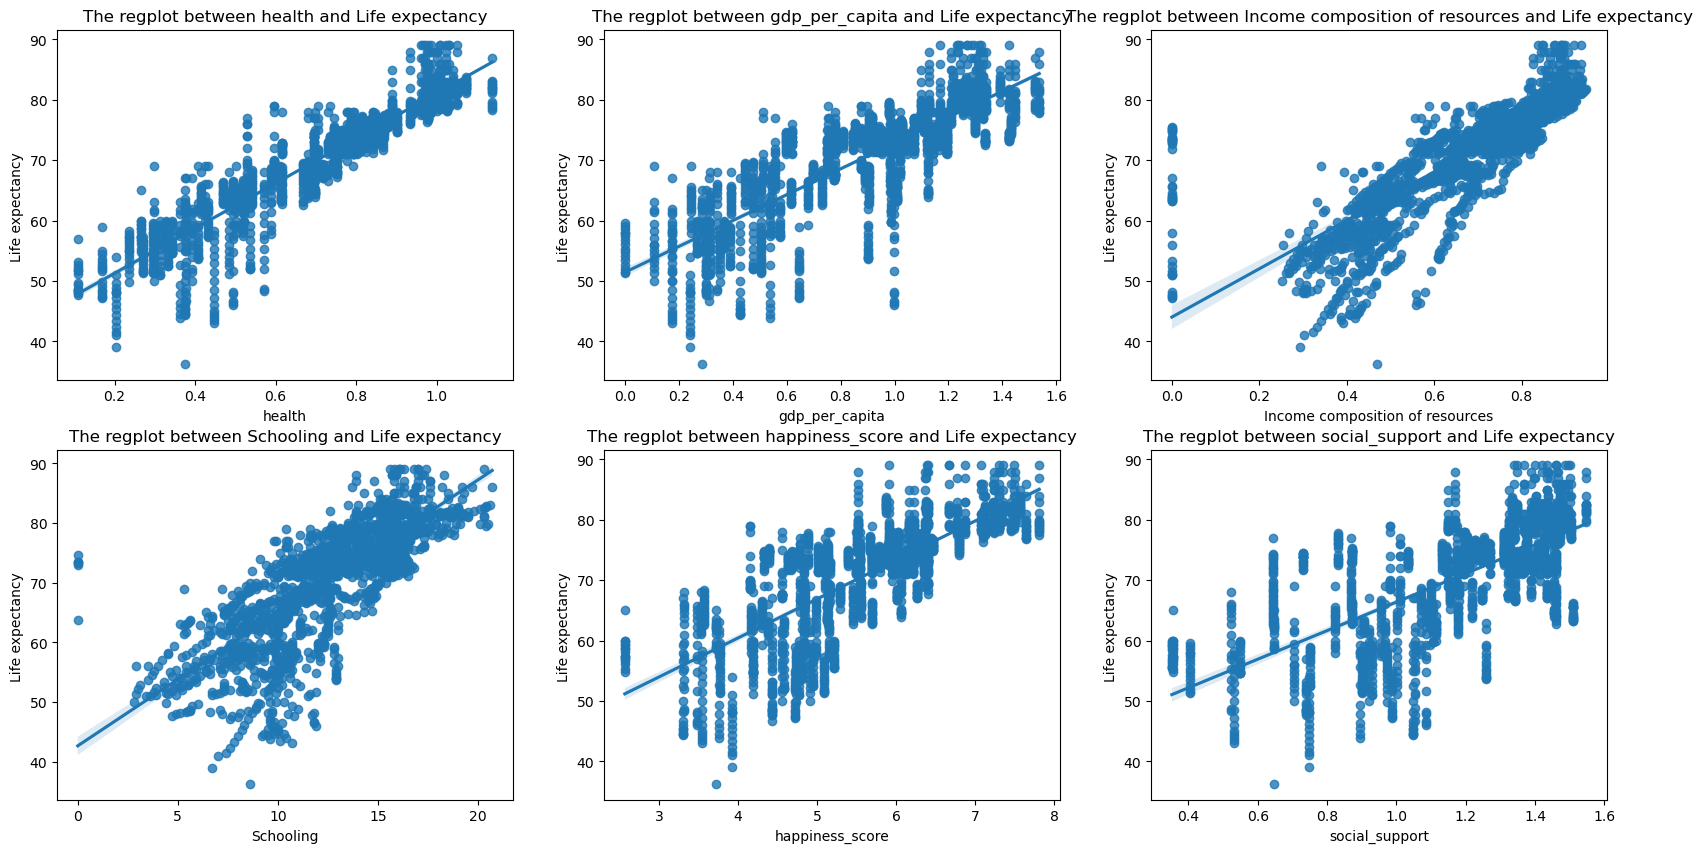

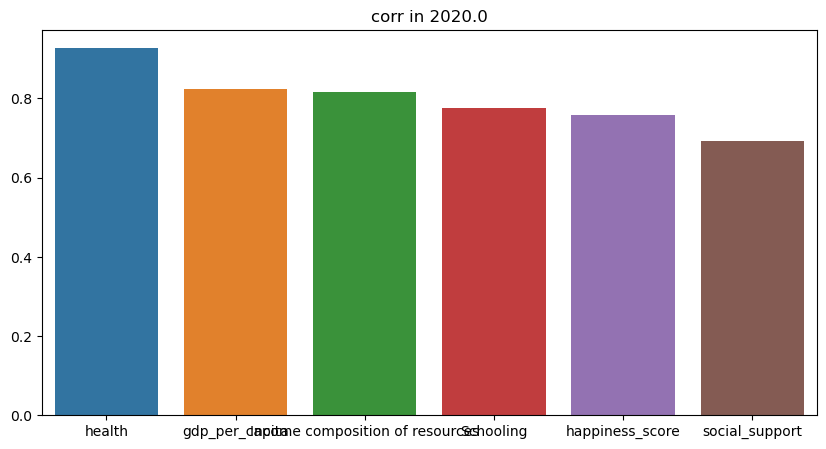

In [22]:
# loop through each country
for year in years: 
    # select data for this country
    data_year=data[data["Year_x"]==year]  
    # Calculate the correlation between the country's life expectancy and other fields, and sort them in descending order, and finally return the field name
    columns_high=data_year.corr().fillna(0).reset_index().loc[:,["index","Life expectancy "]].sort_values(by="Life expectancy ",ascending=False)["index"].values.tolist() 
    # Calculate the correlation between the life of this country and other fields, and sort them in descending order, and finally return the value of life
    values=data_year.corr().fillna(0).reset_index().loc[:,["index","Life expectancy "]].sort_values(by="Life expectancy ",ascending=False)["Life expectancy "].values.tolist()  
    # Get the first six fields
    columns_high=columns_high[1:7]
    # Take the first six life expectancy
    values=values[1:7]  
    plt.figure(figsize=(20,10))
    for i,column in enumerate(columns_high):
        plt.subplot(2,3,i+1)
        # Draw a linear graph of this field and lifetime
        seaborn.regplot(x=column,y="Life expectancy ",data=data_year)  
        plt.title(f"The regplot between {column} and Life expectancy")
    #plt.savefig(f"images/{country} regplot.png")
    plt.figure(figsize=(10,5))
    # field and lifetime correlation bar chart
    seaborn.barplot(x=columns_high,y=values)  
    plt.title(f"Correlation in {year}")
    plt.savefig(f"output_data/{year} corr.png")

In [ ]:
years=data_money.loc[:,["Year_x","Life expectancy "]].groupby("Year_x").mean().reset_index().sort_values("Life expectancy ",ascending=False)["Year_x"].values.tolist()
print(years)

# loop through each year
for year in years: 
    # select data for each year
    data_year = data_money[data_money["Year_x"]==year]
    correlation = data_money.corr().reset_index().loc[:,["index","Life expectancy "]].sort_values(by="Life expectancy ",ascending=False)["index"].values.tolist() 
    values = data_money.corr().reset_index().loc[:,["index","Life expectancy "]].sort_values(by="Life expectancy ",ascending=False)["Life expectancy "].values.tolist()  
    correlation = correlation[1:7]
    values = values[1:7]
    plt.bar(correlation,values)
    plt.title(f"Correlation in {year}")
    plt.savefig(f"output_data/{year} corr.png")
print(correlation)
print(values)
